In [1]:
from Neural_Nets.ThermoNet.Development.ThermoNet import ThermoRegressionNet
from Neural_Nets.ThermoDataset.Development.ThermoDataset import ThermoDataset
from Neural_Nets.ThermoNetActFuncs.Development.ThermoNetActFuncs import Softplus, ChenSundman
from Utils.PlotHandler.Development.PlotHandler import PlotHandler 
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.optim import Rprop, Adam
import torch.autograd as autograd
from Data_Handling.SGTEHandler.Development.SGTEHandler import SGTEHandler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def epoch(net: ThermoRegressionNet, dataloader, loss_func, optimizer):
    epoch_losses = np.zeros([len(dataloader), ])

    for i, (temp, g, _, _, _) in enumerate(dataloader):
        temp = temp.unsqueeze(-1)
        
        # Forward pass
        gibbs_energy = net(temp)
        
        # Get the loss
        loss = loss_func(gibbs_energy, g.float())

        # Backward pass
        net.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses[i] = loss

    #print(gibbs_energy.min(), g.min())
    mean_epoch_loss = epoch_losses.mean()
    #print('Mean epoch loss: ', mean_epoch_loss)
    return mean_epoch_loss

In [3]:
def train(net, dataset):
    # Hyperparameters
    n_epochs = 100
    lr = 0.1
    batch_size = 32
    std_thresh = 0.05

    # Data
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Optimizer
    optimizer = Adam(net.parameters(), lr=lr)
    loss_func = nn.MSELoss()

    losses = []
    
    # Keep track of epoch where learning rate was reduced last
    lr_reduced_last = 0
    
    # Minimum loss to find best net
    min_loss = epoch(net, dataloader, loss_func, optimizer)
    best_net = net

    for i in range(n_epochs):
        #print('-----\nEpoch %i:\n' % i)
        loss = epoch(net, dataloader, loss_func, optimizer)
        losses.append(loss)
        
        if loss < min_loss:
            min_loss = loss
            best_net = net
        
        # Adapt learning rate if standard deviation over the last 10 epochs is below a threshold
        #if np.array(losses[-10:]).std() < std_thresh and (i - lr_reduced_last) >= 10:
            #print('Learning rate halfed! \n')
            #lr_reduced_last = i
            #lr /= 2
    
    return best_net

In [4]:
net = ThermoRegressionNet(hidden_layers=1, hidden_dim=16, act_funcs=None)

element = 'Fe'
phase = ['BCC_A2']
scaling = True
dataset = ThermoDataset(element, phase, step=10, scaling=scaling)

best_net = train(net, dataset)

Fe successfully selected!



C:\Users\danie\anaconda3\envs\5_Programmcodes\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\danie\anaconda3\envs\5_Programmcodes\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Fe successfully selected!



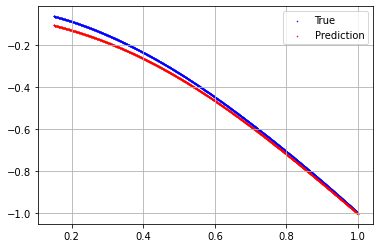

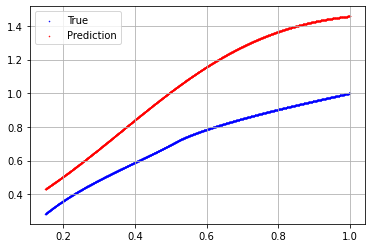

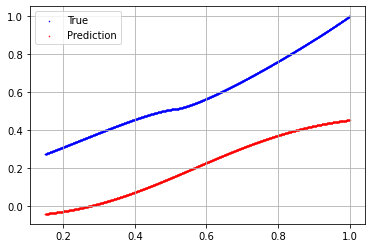

In [5]:
ph = PlotHandler()

ph.properties_temp(best_net, element, phase, scaling=scaling, unscale_output=False)

In [6]:
temp = torch.tensor(list(range(200, 2000)), dtype=torch.float32).unsqueeze(-1)/2000

s, h, c = best_net.output_all(temp)

print(s)
print()
print(h)
print()
print(c)

tensor([[0.3640],
        [0.3647],
        [0.3653],
        ...,
        [1.4567],
        [1.4568],
        [1.4569]], requires_grad=True)

tensor([[-0.0518],
        [-0.0517],
        [-0.0517],
        ...,
        [ 0.4516],
        [ 0.4517],
        [ 0.4518]], grad_fn=<AddBackward0>)

None
